# <b>3 - Machine Learning Application to Process Mined Simulated Random Process for Anomaly Detection</b>

Purpose:   
Experiment with Process Mining to determine if feature extraction can contribute to a ML model for anomaly detection and visual representation of procecss anomalies. 

   
-----

<b>Initial Imports</b>   
Imports for specific techniques handled later

In [2]:
import random
from datetime import datetime, timedelta
import pandas as pd
import pm4py

-----

## <b>Simulation</b>

Summary of the random process:   
There are six forms of the process flow. All begin with 'start' and all terminate with 'end'. There's an 80% chance that the process will follow the first two flows. There's a 14% chance of an approval required on a normal flow. There's a 5% chance of a special approval flow. There's a 1% chance of a process bypass. A random number is used to simulate which flow is followed.   
10,000 simulations were completed.

In [3]:
process_scenarios = {
                    "a": ['start','a','b','c','end'],
                    "b": ['start','a','d','e','end'],
                    "c": ['start','a','b','c','a_approval','end'],
                    "d": ['start','a','d','e','b_approval','end'],
                    "e": ['start','a','f','f_approval','end'],
                    "f": ['start','bypass','end']
                    }

In [4]:
def get_action_date(f_days):
    process_start_date = datetime(2001,1,1)
    return process_start_date + timedelta(f_days)
    

In [5]:
def get_scenario(f_rand_val, f_scenarios, f_outlier):
    if f_outlier == 0:
        tmp_val = ''
        tmp_val = f_scenarios['a'] if (f_rand_val <= 40) else tmp_val                              # 40% chance A
        tmp_val = f_scenarios['b'] if (f_rand_val > 40 and f_rand_val <= 80) else tmp_val          # 40% chance B
        tmp_val = f_scenarios['c'] if (f_rand_val > 80 and f_rand_val <= 87) else tmp_val          # 7% chance C
        tmp_val = f_scenarios['d'] if (f_rand_val > 87 and f_rand_val <= 94) else tmp_val          # 7% chance D
        tmp_val = f_scenarios['e'] if (f_rand_val > 94 and f_rand_val <= 99) else tmp_val          # 5% chance E
        tmp_val = f_scenarios['f'] if (f_rand_val > 99) else tmp_val                               # 1% chance F
    if f_outlier == 1:
        tmp_val = ''                                                                               # 0% chance A or B
        tmp_val = f_scenarios['c'] if (f_rand_val <= 5) else tmp_val                               # 5% chance C
        tmp_val = f_scenarios['d'] if (f_rand_val > 5 and f_rand_val <= 10) else tmp_val           # 5% chance D
        tmp_val = f_scenarios['e'] if (f_rand_val > 10 and f_rand_val <= 99) else tmp_val          # 89% chance E
        tmp_val = f_scenarios['f'] if (f_rand_val > 99) else tmp_val                               # 1% chance F
    return tmp_val

In [6]:
def simulate_event(f_flow_id, f_date_id, f_outlier_flag):
    rand_event = int( round( random.random() * 100 , 2))
    tmp_date_id = f_date_id
    flow_scenario = get_scenario( rand_event, process_scenarios ,f_outlier_flag)
    tmp_flow = []
    for flow in flow_scenario: 
        event_date = get_action_date(tmp_date_id)
        tmp_date_id += 1
        tmp_flow.append([f_flow_id, event_date.strftime('%m/%d/%Y'), flow])
    return tmp_flow, tmp_date_id

In [7]:
date_id = 1
flow_id = 1
simulation_list = []
while flow_id < 10001:
    if flow_id > 5000 and flow_id <= 5501: 
        outlier_flag = 1
    else: 
        outlier_flag = 0
    sim_flow, date_id = simulate_event(flow_id, date_id,outlier_flag)
    for event in sim_flow:
        simulation_list.append(event)
    flow_id += 1

In [8]:
simulation_df = pd.DataFrame(simulation_list)

In [9]:
simulation_df.columns = ['flow_id','event_date','event']

----- 

## <b>Process Mining</b>

### <b>Process Mining Log Conversion</b>

In [10]:
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

In [11]:
sim_event_df = dataframe_utils.convert_timestamp_columns_in_df(simulation_df)

In [12]:
sim_event_df = sim_event_df.sort_values('event_date')

In [13]:
sim_event_df.columns = ['case:concept:name','time:timestamp','concept:name']

In [14]:
sim_normevent_df = sim_event_df[sim_event_df['case:concept:name'] < 5000]
sim_outevent_df = sim_event_df[(sim_event_df['case:concept:name'] > 5000) & (sim_event_df['case:concept:name'] < 5500) ]

In [15]:
log_util_params = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:concept:name'}

In [16]:
sim_event_log = log_converter.apply(sim_event_df, parameters=log_util_params, variant=log_converter.Variants.TO_EVENT_LOG)
sim_normevent_log = log_converter.apply(sim_normevent_df, parameters=log_util_params, variant=log_converter.Variants.TO_EVENT_LOG)
sim_outevent_log = log_converter.apply(sim_outevent_df, parameters=log_util_params, variant=log_converter.Variants.TO_EVENT_LOG)

### <b>Alpha Miner</b>

In [17]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petrinet import visualizer as pn_visualizer
viz_params = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

To demonstrate the difference between expected normal and temporal outlier period, the process maps are visualized respectively

In [18]:
all_net, all_initial_marking, all_final_marking = alpha_miner.apply(sim_event_log)
norm_net, norm_initial_marking, norm_final_marking = alpha_miner.apply(sim_normevent_log)
out_net, out_initial_marking, out_final_marking = alpha_miner.apply(sim_outevent_log)

Expected normal flow

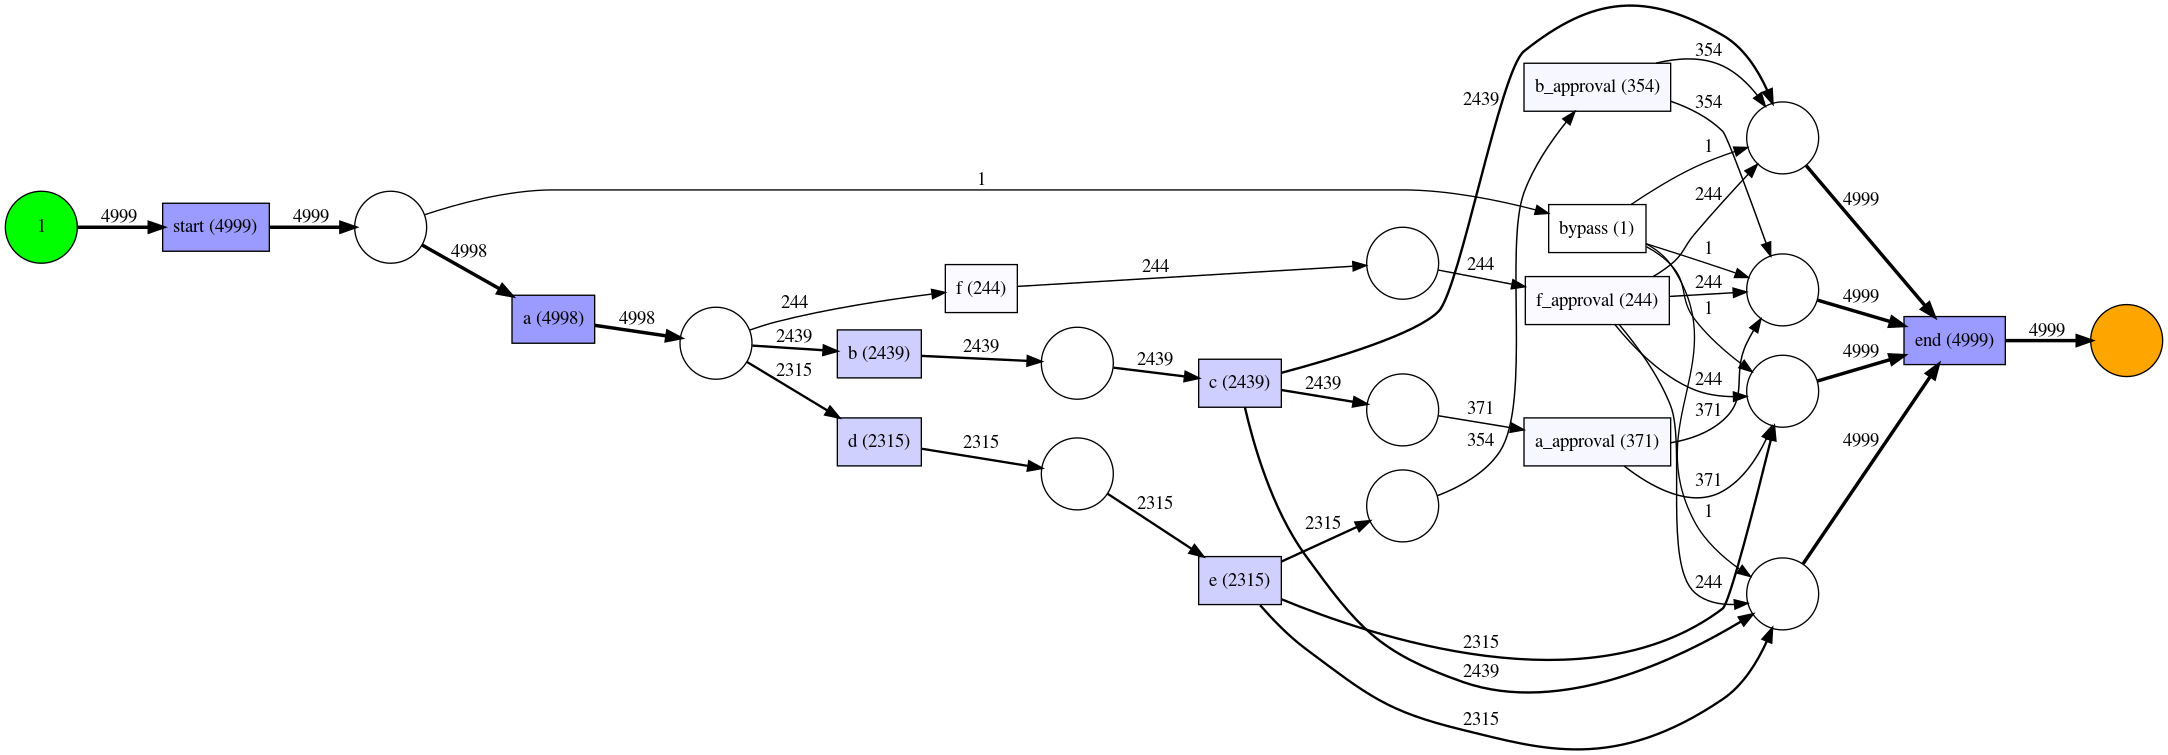

In [30]:
norm_gviz_am = pn_visualizer.apply(norm_net, norm_initial_marking, norm_final_marking,
                             parameters = viz_params,
                             variant=pn_visualizer.Variants.FREQUENCY,
                             log=sim_normevent_log)
pn_visualizer.view(norm_gviz_am)

Outlier flow

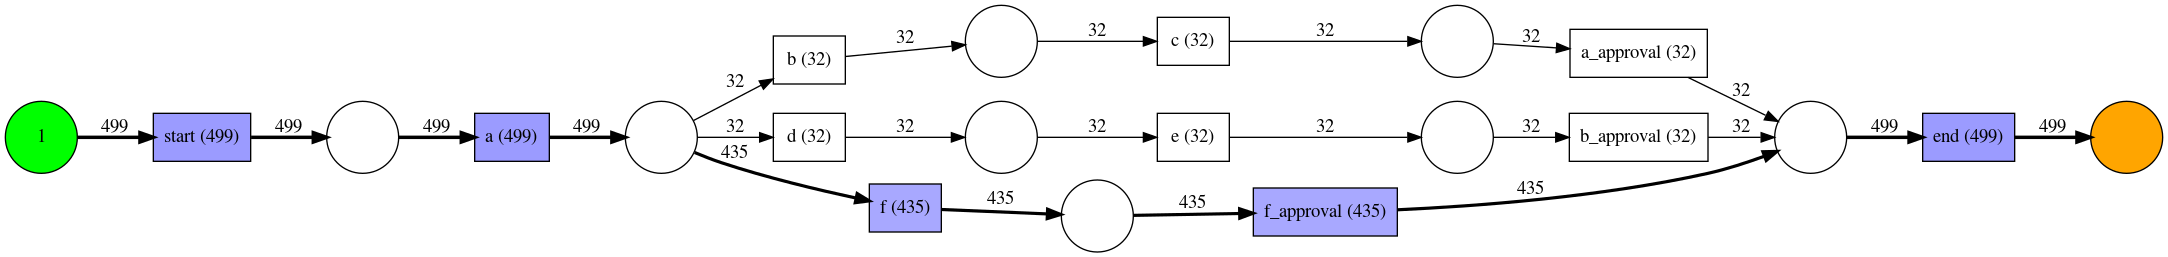

In [31]:
out_gviz_am = pn_visualizer.apply(out_net, out_initial_marking, out_final_marking,
                             parameters = viz_params,
                             variant=pn_visualizer.Variants.FREQUENCY,
                             log=sim_outevent_log)
pn_visualizer.view(out_gviz_am)

In [ ]:
from pm4py.objects.log.util import get_log_representation

In [280]:
def neighbors_metrics(f_log):
    """
    Intakes the log for a temporal window. 
    Processes case count metrics for in scope event neighbors. 
    Returns pandas dataframe. 
    """
    try:
        tmp_data, tmp_feature_names = get_log_representation.get_representation(f_log, str_ev_attr=["case:concept:name", "concept:name"],
                                                                    str_tr_attr=[], num_ev_attr=[], num_tr_attr=[],
                                                                    str_evsucc_attr=["case:concept:name", "concept:name"])
        tmp_df = pd.DataFrame(tmp_data, columns = tmp_feature_names)
        tmp_agg = pd.DataFrame( tmp_df.sum() )
        tmp_agg.columns = ['case_count']
        tmp_agg = tmp_agg.iloc[tmp_agg.index.str.contains('success')]
        tmp_agg = tmp_agg.iloc[~tmp_agg.index.str.contains('case:concept')]
        tmp_agg.index = tmp_agg.index.str.replace('succession:concept:name@','')
        tmp_agg.index = tmp_agg.index.str.replace('#','_to_')
        tot_case_cnt = tmp_agg['case_count'].max()
        tmp_agg['norm_val'] = tmp_agg.loc[:,'case_count'].apply(lambda x : x / tot_case_cnt)
        tmp_agg = pd.DataFrame( tmp_agg.loc[~tmp_agg.index.isin(['start_to_a']), 'norm_val'] ) 
        base_neighbors_df = pd.DataFrame( [0,0,0,0,0,0,0,0,0,0,0,0,0] )
        base_neighbors_df.index = ['a_to_b',
         'a_to_d',
         'a_to_f',
         'a_approval_to_end',
         'b_to_c',
         'b_approval_to_end',
         'c_to_a_approval',
         'c_to_end',
         'd_to_e',
         'e_to_b_approval',
         'e_to_end',
         'f_to_f_approval',
         'f_approval_to_end']

        norm_merge = base_neighbors_df.merge(tmp_agg, how='left', left_index=True,right_index=True)
        norm_merge['norm_val'] = norm_merge['norm_val'].fillna(0)
        fnl_row = norm_merge['norm_val'].T.to_list()
        fnl = pd.DataFrame( [fnl_row] )
        fnl.columns = ['a_to_b',
         'a_to_d',
         'a_to_f',
         'a_approval_to_end',
         'b_to_c',
         'b_approval_to_end',
         'c_to_a_approval',
         'c_to_end',
         'd_to_e',
         'e_to_b_approval',
         'e_to_end',
         'f_to_f_approval',
         'f_approval_to_end']
        return fnl
    except:
        print('Error in processing metrics')

In [243]:
test_func = neighbors_metrics(sim_event_log)

In [244]:
test_func

,a_to_b,a_to_d,a_to_f,a_approval_to_end,b_to_c,b_approval_to_end,c_to_a_approval,c_to_end,d_to_e,e_to_b_approval,e_to_end,f_to_f_approval,f_approval_to_end
0,0.4626,0.4446,0.0928,0.0701,0.4626,0.0718,0.0701,0.3925,0.4446,0.0718,0.3728,0.0928,0.0928


In [281]:
batch_event_range = range(0,10000,100)
results_df = pd.DataFrame(columns = ['a_to_b',
         'a_to_d',
         'a_to_f',
         'a_approval_to_end',
         'b_to_c',
         'b_approval_to_end',
         'c_to_a_approval',
         'c_to_end',
         'd_to_e',
         'e_to_b_approval',
         'e_to_end',
         'f_to_f_approval',
         'f_approval_to_end'])
for batch in batch_event_range: 
    batch_sim_df = sim_event_df[(sim_event_df['case:concept:name'] >= batch) & (sim_event_df['case:concept:name'] < batch + 100)]
    batch_sim_log = log_converter.apply(batch_sim_df, parameters=log_util_params, variant=log_converter.Variants.TO_EVENT_LOG)
    batch_metrics = neighbors_metrics(batch_sim_log)
    batch_metrics.index = [batch]
    results_df = results_df.append(batch_metrics, ignore_index=False)

In [283]:
results_df.head()

,a_to_b,a_to_d,a_to_f,a_approval_to_end,b_to_c,b_approval_to_end,c_to_a_approval,c_to_end,d_to_e,e_to_b_approval,e_to_end,f_to_f_approval,f_approval_to_end
0,0.545455,0.383838,0.070707,0.080808,0.545455,0.070707,0.080808,0.464646,0.383838,0.070707,0.313131,0.070707,0.070707
100,0.440000,0.530000,0.030000,0.050000,0.440000,0.120000,0.050000,0.390000,0.530000,0.120000,0.410000,0.030000,0.030000
200,0.480000,0.450000,0.070000,0.070000,0.480000,0.050000,0.070000,0.410000,0.450000,0.050000,0.400000,0.070000,0.070000
300,0.560000,0.410000,0.030000,0.080000,0.560000,0.060000,0.080000,0.480000,0.410000,0.060000,0.350000,0.030000,0.030000
400,0.440000,0.540000,0.020000,0.080000,0.440000,0.090000,0.080000,0.360000,0.540000,0.090000,0.450000,0.020000,0.020000


In [282]:
results_df.iloc[ results_df.index == 5000]

,a_to_b,a_to_d,a_to_f,a_approval_to_end,b_to_c,b_approval_to_end,c_to_a_approval,c_to_end,d_to_e,e_to_b_approval,e_to_end,f_to_f_approval,f_approval_to_end
5000,0.03,0.03,0.94,0.03,0.03,0.03,0.03,0.0,0.03,0.03,0.0,0.94,0.94


In [19]:
from pm4py.objects.log.util import get_log_representation

In [90]:
data, feature_names = get_log_representation.get_representation(sim_event_log, str_ev_attr=["case:concept:name", "concept:name"],
                                                                str_tr_attr=[], num_ev_attr=[], num_tr_attr=[],
                                                                str_evsucc_attr=["case:concept:name", "concept:name"])

In [91]:
test_df2 = pd.DataFrame(data, columns = feature_names)

In [157]:
test_agg = pd.DataFrame( test_df2.sum() )

In [158]:
test_agg.columns = ['case_count']

In [159]:
test_agg = test_agg.iloc[test_agg.index.str.contains('success')]

In [160]:
test_agg  = test_agg.iloc[~test_agg.index.str.contains('case:concept')]

In [161]:
test_agg.index = test_agg.index.str.replace('succession:concept:name@','')

In [162]:
test_agg.index = test_agg.index.str.replace('#','_to_')

In [163]:
tot_case_cnt = test_agg['case_count'].max()
test_agg['norm_val'] = test_agg.loc[:,'case_count'].apply(lambda x : x / tot_case_cnt)

In [164]:
test_agg

,case_count,norm_val
a_to_b,4626,0.4626
a_to_d,4446,0.4446
a_to_f,928,0.0928
a_approval_to_end,701,0.0701
b_to_c,4626,0.4626
b_approval_to_end,718,0.0718
c_to_a_approval,701,0.0701
c_to_end,3925,0.3925
d_to_e,4446,0.4446
e_to_b_approval,718,0.0718


In [165]:
test_agg2 = pd.DataFrame( test_agg.loc[~test_agg.index.isin(['start_to_a']), 'norm_val'] ) 

In [166]:
test_agg2

,norm_val
a_to_b,0.4626
a_to_d,0.4446
a_to_f,0.0928
a_approval_to_end,0.0701
b_to_c,0.4626
b_approval_to_end,0.0718
c_to_a_approval,0.0701
c_to_end,0.3925
d_to_e,0.4446
e_to_b_approval,0.0718


In [173]:
test_agg2.index.to_list()

['a_to_b',
 'a_to_d',
 'a_to_f',
 'a_approval_to_end',
 'b_to_c',
 'b_approval_to_end',
 'c_to_a_approval',
 'c_to_end',
 'd_to_e',
 'e_to_b_approval',
 'e_to_end',
 'f_to_f_approval',
 'f_approval_to_end']

In [167]:
base_neighbors_df = pd.DataFrame( [0,0,0,0,0,0,0,0,0,0,0,0,0] )

In [174]:
base_neighbors_df.index = ['a_to_b',
 'a_to_d',
 'a_to_f',
 'a_approval_to_end',
 'b_to_c',
 'b_approval_to_end',
 'c_to_a_approval',
 'c_to_end',
 'd_to_e',
 'e_to_b_approval',
 'e_to_end',
 'f_to_f_approval',
 'f_approval_to_end']

In [175]:
norm_merge = base_neighbors_df.merge(test_agg2, how='left', left_index=True,right_index=True)

In [177]:
norm_merge['norm_val'] = norm_merge['norm_val'].fillna(0)

In [178]:
fnl_row = norm_merge['norm_val'].T.to_list()

In [179]:
fnl_row

[0.4626,
 0.4446,
 0.0928,
 0.0701,
 0.4626,
 0.0718,
 0.0701,
 0.3925,
 0.4446,
 0.0718,
 0.3728,
 0.0928,
 0.0928]

In [180]:
test_format = []

In [185]:
test_format.append([3,fnl_row])

In [186]:
test_format2 = pd.DataFrame(test_format)

In [187]:
test_format2

,0,1
0,1,"[0.4626, 0.4446, 0.0928, 0.0701, 0.4626, 0.071..."
1,2,"[0.4626, 0.4446, 0.0928, 0.0701, 0.4626, 0.071..."
2,3,"[0.4626, 0.4446, 0.0928, 0.0701, 0.4626, 0.071..."


In [80]:
test_agg3 = test_agg2.T

In [82]:
test_agg3

,a_approval,b,b_approval,c,d,e,f,f_approval
norm_val,0.0701,0.4626,0.0718,0.4626,0.4446,0.4446,0.0928,0.0928


In [89]:
base_event_df = pd.DataFrame([0,0,0,0,0,0,0,0])

In [87]:
base_event_df.columns = ['a_approval','b','b_approval','c','d','e','f','f_approval']

In [88]:
base_event_df

,a_approval,b,b_approval,c,d,e,f,f_approval
0,0,0,0,0,0,0,0,0


In [86]:
base_event_df.shape

(1, 8)

In [43]:
data, feature_names = get_log_representation.get_representation(sim_event_log, str_ev_attr=["case:concept:name", "concept:name"],
                                                                str_tr_attr=[], num_ev_attr=[], num_tr_attr=[],
                                                                str_evsucc_attr=["case:concept:name", "concept:name"])

In [45]:
test_df2 = pd.DataFrame(data, columns = feature_names)

In [46]:
test_df2.head()

,event:case:concept:name@UNDEFINED,event:concept:name@a,event:concept:name@a_approval,event:concept:name@b,event:concept:name@b_approval,event:concept:name@bypass,event:concept:name@c,event:concept:name@d,event:concept:name@e,event:concept:name@end,...,succession:concept:name@bypass#end,succession:concept:name@c#a_approval,succession:concept:name@c#end,succession:concept:name@d#e,succession:concept:name@e#b_approval,succession:concept:name@e#end,succession:concept:name@f#f_approval,succession:concept:name@f_approval#end,succession:concept:name@start#a,succession:concept:name@start#bypass
0,1,1,0,0,1,0,0,1,1,1,...,0,0,0,1,1,0,0,0,1,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,1,0
2,1,1,0,0,0,0,0,1,1,1,...,0,0,0,1,0,1,0,0,1,0
3,1,1,0,0,0,0,0,1,1,1,...,0,0,0,1,0,1,0,0,1,0
4,1,1,1,1,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0


In [52]:
from sklearn.decomposition import PCA

In [64]:
pca = PCA(n_components = 5)

In [65]:
test_df3 = pd.DataFrame(pca.fit_transform(test_df2))

In [47]:
from sklearn.ensemble import IsolationForest

In [66]:
model = IsolationForest()

In [71]:
model.fit(test_df2)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [72]:
test_df2['scores'] = model.decision_function(test_df2)

In [69]:
test_df3['@@index'] = test_df3.index
test_df3 = test_df3[['scores','@@index']]
test_df3 = test_df3.sort_values('scores')

In [75]:
test_df2 = test_df2.sort_values('scores')

In [77]:
test_df2.head(10)

,event:case:concept:name@UNDEFINED,event:concept:name@a,event:concept:name@a_approval,event:concept:name@b,event:concept:name@b_approval,event:concept:name@bypass,event:concept:name@c,event:concept:name@d,event:concept:name@e,event:concept:name@end,...,succession:concept:name@c#a_approval,succession:concept:name@c#end,succession:concept:name@d#e,succession:concept:name@e#b_approval,succession:concept:name@e#end,succession:concept:name@f#f_approval,succession:concept:name@f_approval#end,succession:concept:name@start#a,succession:concept:name@start#bypass,scores
5671,1,1,1,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,-0.108262
5217,1,1,1,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,-0.108262
5166,1,1,1,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,-0.108262
749,1,1,1,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,-0.108262
5125,1,1,1,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,-0.108262
5118,1,1,1,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,-0.108262
5096,1,1,1,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,-0.108262
5086,1,1,1,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,-0.108262
5077,1,1,1,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,-0.108262
5074,1,1,1,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,-0.108262


In [80]:
simulation_df[ simulation_df['flow_id'] == 5671]

,flow_id,event_date,event
29170,5671,2080-11-13 00:00:00+00:00,start
29171,5671,2080-11-14 00:00:00+00:00,a
29172,5671,2080-11-15 00:00:00+00:00,b
29173,5671,2080-11-16 00:00:00+00:00,c
29174,5671,2080-11-17 00:00:00+00:00,end


In [81]:
simulation_df.head(100)

,flow_id,event_date,event
0,1,2001-01-02 00:00:00+00:00,start
1,1,2001-01-03 00:00:00+00:00,a
2,1,2001-01-04 00:00:00+00:00,d
3,1,2001-01-05 00:00:00+00:00,e
4,1,2001-01-06 00:00:00+00:00,b_approval
...,...,...,...
95,18,2001-04-07 00:00:00+00:00,end
96,19,2001-04-08 00:00:00+00:00,start
97,19,2001-04-09 00:00:00+00:00,a
98,19,2001-04-10 00:00:00+00:00,b
